In [ ]:
# @title 📊 GA4 LLM & Search Analyse (FIXED Version)
# ==============================================================================
# 1. SETUP & FIX
# ==============================================================================
# Wir installieren explizit version 0.8.0 für 'run_console' Support
!pip install -q google-auth-oauthlib==0.8.0 pandas matplotlib seaborn google-api-python-client google-auth-httplib2

import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import userdata
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# ==============================================================================
# 2. KONFIGURATION
# ==============================================================================
SCOPES = [
    'https://www.googleapis.com/auth/analytics.readonly',
    'https://www.googleapis.com/auth/analytics.edit'
]

LLM_SOURCES = ['chatgpt', 'claude', 'gemini', 'perplexity', 'copilot', 'openai', 'bing chat', 'bard']
SEARCH_ENGINES = ['google', 'bing', 'yahoo', 'duckduckgo', 'ecosia', 'startpage']

# ==============================================================================
# 3. HELPER FUNKTIONEN
# ==============================================================================
def authenticate_analytics():
    print("\n🔐 Starte Authentifizierung...")
    try:
        c_id = userdata.get('client-id-colab')
        c_secret = userdata.get('client-secret-colab')
    except Exception:
        print("❌ FEHLER: Secrets fehlen. Bitte 'client-id-colab' und 'client-secret-colab' prüfen.")
        return None

    config = {
        "installed": {
            "client_id": c_id,
            "client_secret": c_secret,
            "auth_uri": "https://accounts.google.com/o/oauth2/auth",
            "token_uri": "https://oauth2.googleapis.com/token",
            "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
            "redirect_uris": ["urn:ietf:wg:oauth:2.0:oob", "http://localhost"]
        }
    }

    try:
        flow = InstalledAppFlow.from_client_config(config, SCOPES)
        creds = flow.run_console(prompt='consent')
        return creds
    except AttributeError:
        print("❌ Fehler: 'run_console' fehlt. Bitte Runtime neu starten und pip install Block beachten.")
        return None
    except Exception as e:
        print(f"❌ Auth Fehler: {e}")
        return None

def classify_channel(row):
    source = str(row['Source']).lower()
    medium = str(row['Medium']).lower()

    if any(llm in source for llm in LLM_SOURCES):
        return "LLM / AI Chat"

    if any(eng in source for eng in SEARCH_ENGINES):
        if 'organic' in medium or (source == 'bing' and medium == 'referral'):
            return "Organic Search"

    return "Andere Kanäle"

# ==============================================================================
# 4. HAUPTPROGRAMM (MIT FIX)
# ==============================================================================
def main():
    creds = authenticate_analytics()
    if not creds: return

    # --- B. Property Auswahl (Admin API) ---
    try:
        admin_service = build('analyticsadmin', 'v1beta', credentials=creds)
        print("\n🔍 Lade Properties...")

        response = admin_service.accountSummaries().list().execute()
        summaries = response.get('accountSummaries', [])

        # --- FIX START: Hier entpacken wir die verschachtelte Struktur ---
        props = []
        for account in summaries:
            # Ein Account kann mehrere Properties haben ("propertySummaries")
            property_list = account.get('propertySummaries', [])
            for p in property_list:
                p_resource = p.get('property') # Format "properties/123456"
                if p_resource:
                    p_id = p_resource.split('/')[1]
                    p_name = p.get('displayName', 'Unbekannt')
                    # Wir merken uns auch den Account-Namen zur besseren Übersicht
                    acc_name = account.get('displayName', 'Unbekanntes Konto')
                    props.append({'name': p_name, 'id': p_id, 'account': acc_name})
        # --- FIX ENDE ---

        if not props:
            print("❌ Keine Properties gefunden (Liste ist leer).")
            return

        print(f"✅ {len(props)} Properties gefunden:")
        for i, p in enumerate(props):
            print(f"[{i}] {p['account']} -> {p['name']} (ID: {p['id']})")

        sel = input("\n👉 Bitte Nummer wählen (z.B. 0): ")
        try:
            selected_prop = props[int(sel)]
            PROPERTY_ID = selected_prop['id']
            print(f"\n🚀 Analysiere: {selected_prop['name']} (ID: {PROPERTY_ID})...")
        except:
            print("❌ Ungültige Eingabe.")
            return

    except Exception as e:
        print(f"❌ Fehler bei Property Auswahl: {e}")
        return

    # --- C. Datenabruf (Data API) ---
    try:
        data_service = build('analyticsdata', 'v1beta', credentials=creds)
        DATE_RANGE = [{"startDate": "90daysAgo", "endDate": "yesterday"}]

        print("📊 Lade Traffic & Revenue...")
        req_traffic = {
            "dateRanges": DATE_RANGE,
            "dimensions": [{"name": "sessionSource"}, {"name": "sessionMedium"}],
            "metrics": [{"name": "sessions"}, {"name": "ecommercePurchases"}, {"name": "purchaseRevenue"}]
        }
        res_traffic = data_service.properties().runReport(property=f"properties/{PROPERTY_ID}", body=req_traffic).execute()

        print("🎯 Lade Leads (Event: generate_lead)...")
        req_leads = {
            "dateRanges": DATE_RANGE,
            "dimensions": [{"name": "sessionSource"}, {"name": "sessionMedium"}],
            "metrics": [{"name": "eventCount"}],
            "dimensionFilter": {"filter": {"fieldName": "eventName", "stringFilter": {"value": "generate_lead"}}}
        }
        res_leads = data_service.properties().runReport(property=f"properties/{PROPERTY_ID}", body=req_leads).execute()

        # --- D. Verarbeitung ---
        data_t = []
        for row in res_traffic.get('rows', []):
            data_t.append({
                'Source': row['dimensionValues'][0]['value'],
                'Medium': row['dimensionValues'][1]['value'],
                'Sessions': int(row['metricValues'][0]['value']),
                'Purchases': int(row['metricValues'][1]['value']),
                'Revenue': float(row['metricValues'][2]['value'])
            })
        df = pd.DataFrame(data_t)

        data_l = []
        for row in res_leads.get('rows', []):
            data_l.append({
                'Source': row['dimensionValues'][0]['value'],
                'Medium': row['dimensionValues'][1]['value'],
                'Leads': int(row['metricValues'][0]['value'])
            })
        df_l = pd.DataFrame(data_l)

        if not df.empty:
            if not df_l.empty:
                df = pd.merge(df, df_l, on=['Source', 'Medium'], how='left')
                df['Leads'] = df['Leads'].fillna(0)
            else:
                df['Leads'] = 0

            df['Channel_Group'] = df.apply(classify_channel, axis=1)

            df_analysis = df.groupby('Channel_Group').agg({
                'Sessions': 'sum', 'Purchases': 'sum', 'Revenue': 'sum', 'Leads': 'sum'
            }).reset_index()

            # Divisions durch Null verhindern
            df_analysis['Conv. Rate (Kauf) %'] = df_analysis.apply(lambda x: (x['Purchases']/x['Sessions']*100) if x['Sessions']>0 else 0, axis=1)
            df_analysis['Conv. Rate (Lead) %'] = df_analysis.apply(lambda x: (x['Leads']/x['Sessions']*100) if x['Sessions']>0 else 0, axis=1)
            df_analysis['Umsatz pro Session'] = df_analysis.apply(lambda x: (x['Revenue']/x['Sessions']) if x['Sessions']>0 else 0, axis=1)

            df_analysis = df_analysis.sort_values('Sessions', ascending=False)

            print("\n" + "="*50)
            print(f"ANALYSE ERGEBNIS: {selected_prop['name']}")
            print("="*50)
            pd.options.display.float_format = '{:,.2f}'.format
            print(df_analysis.to_markdown(index=False))

            print("\n📈 Generiere Grafiken...")
            sns.set_theme(style="whitegrid")
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            sns.barplot(data=df_analysis, x='Channel_Group', y='Sessions', ax=axes[0], palette="viridis")
            axes[0].set_title('Traffic Volumen')
            sns.barplot(data=df_analysis, x='Channel_Group', y='Conv. Rate (Kauf) %', ax=axes[1], palette="magma")
            axes[1].set_title('CR Purchase (%)')
            sns.barplot(data=df_analysis, x='Channel_Group', y='Umsatz pro Session', ax=axes[2], palette="rocket")
            axes[2].set_title('Wert (Umsatz/Session)')
            plt.tight_layout()
            plt.show()

            print("\n🤖 LLM Detail-Traffic:")
            llm_df = df[df['Channel_Group'] == 'LLM / AI Chat'].groupby('Source').agg({'Sessions':'sum', 'Purchases':'sum'}).sort_values('Sessions', ascending=False)
            if not llm_df.empty:
                print(llm_df.to_markdown())
            else:
                print("Kein LLM Traffic gefunden.")
        else:
            print("⚠️ Keine Daten verfügbar.")

    except HttpError as e:
        print(f"❌ API Fehler: {e}")
    except Exception as e:
        print(f"❌ Fehler: {e}")

if __name__ == "__main__":
    main()


🔐 Starte Authentifizierung...
Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=611889279952-f4ngn9emgn9g0slc5kg9d8l6kcplok56.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.edit&state=zF2v7xBqIbCaLDJKKY78FVXGB1QR32&prompt=consent&access_type=offline
Enter the authorization code: 4/1ASc3gC3iSNLWe_A95FwLBgPLJx6lkhGBnLR7uAb3W6Bq8T2dkmorSXDAF10

🔍 Lade Properties...
✅ 15 Properties gefunden:
[0] GrowingBoss -> growinboss.ch  – GA4 (ID: 266282887)
[1] Seiten -> stiuvou.ch  – GA4 (ID: 309518679)
[2] Blogs -> Travelita 2 (ID: 249602934)
[3] Blogs -> travelita-blog.com (ID: 427895616)
[4] swisspeace Projects -> -- inactive -- academy.swisspeace.ch GA 3 - GA4 (ID: 366108856)
[5] flin Tools -> crawltrack (ID: 497854888)
[6] chatbot-travelita -> chatbot-travelita (ID: 508485084


🔐 Starte Authentifizierung...
Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=611889279952-f4ngn9emgn9g0slc5kg9d8l6kcplok56.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.edit&state=G0gKP5jorwisRjre8qR80JNekNKZ0f&prompt=consent&access_type=offline
Enter the authorization code: 4/1ASc3gC2Xlr19OAdcZobhgyFpHoua49gKQ2UzcXPy9Ek4YUn4Kyi22WDqYas

🔍 Starte Analyse für das Jahr 2025 (2025-01-01 bis 2025-12-31)...
✅ 15 Properties gefunden.


Analysiere 2025: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]



📊 JAHRESRÜCKBLICK 2025 (1 Properties)
|   Month |   LLM / AI Chat |   Organic Search |
|--------:|----------------:|-----------------:|
|  202501 |         50      |         100      |
|  202502 |         48.5084 |         101.419  |
|  202503 |         57.5968 |          98.7683 |
|  202504 |         54.1557 |          93.2954 |
|  202505 |         41.604  |          95.592  |
|  202506 |         95.1808 |          93.8772 |
|  202507 |         51.6603 |          95.3095 |
|  202508 |         52.5331 |          91.8057 |
|  202509 |         46.0048 |          93.1594 |
|  202510 |         45.6031 |          94.4198 |
|  202511 |         49.5977 |          88.324  |
|  202512 |         56.0375 |          89.6667 |


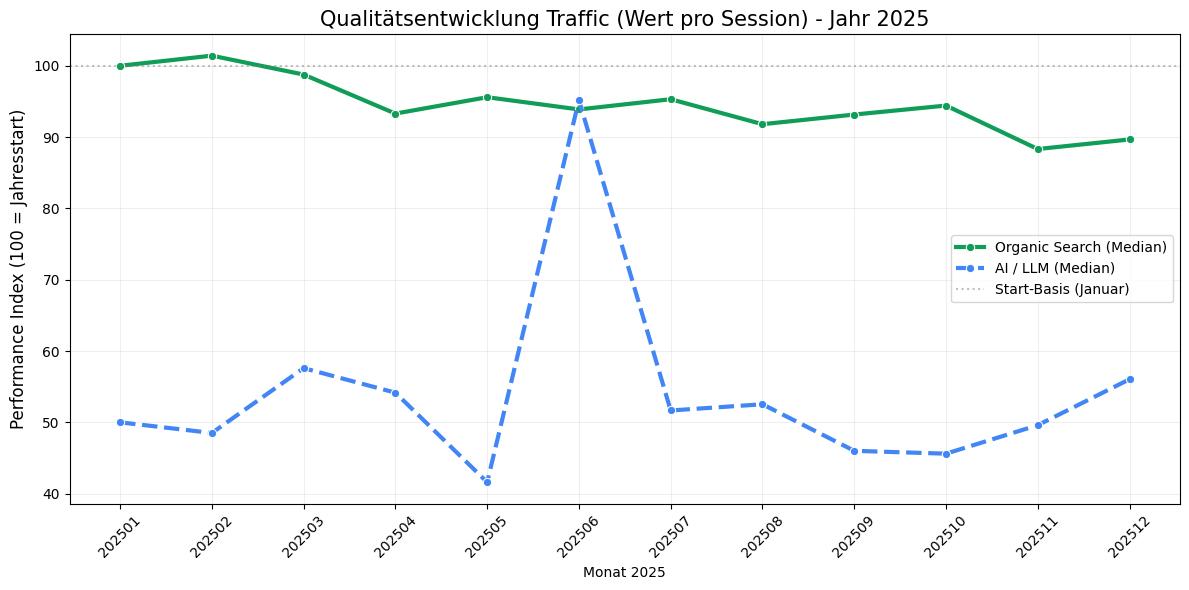

In [ ]:
# @title 📅 Jahresrückblick 2025: Value per Session Analyse
# ==============================================================================
# Fester Zeitraum: 1. Jan 2025 bis 31. Dez 2025
# Ziel: Hat sich der Traffic im Jahr 2025 qualitativ verbessert?
# ==============================================================================

import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# --- KONFIGURATION 2025 ---
START_DATE = "2025-01-01"
END_DATE   = "2025-12-31"
MIN_SESSIONS_MONTHLY = 30  # Etwas toleranter für kleinere Properties

# --- HELPER: KANAL CLASSIFIER ---
def classify_channel_2025(row):
    source = str(row['Source']).lower()
    medium = str(row['Medium']).lower()

    # AI / LLM Traffic
    llm_sources = ['chatgpt', 'claude', 'gemini', 'perplexity', 'copilot', 'openai', 'bing chat', 'bard']
    if any(x in source for x in llm_sources):
        return "LLM / AI Chat"

    # Organic Search
    search_engines = ['google', 'bing', 'yahoo', 'duckduckgo', 'ecosia', 'startpage']
    if any(x in source for x in search_engines):
        if 'organic' in medium or (source == 'bing' and medium == 'referral'):
            return "Organic Search"

    return "Andere"

def get_data_2025(service, property_id):
    """Holt Daten exakt für das Jahr 2025."""
    # Wir versuchen erst die neuen 'keyEvents', sonst 'conversions'
    metrics_try = [{"name": "sessions"}, {"name": "purchaseRevenue"}, {"name": "keyEvents"}]

    req_body = {
        "dateRanges": [{"startDate": START_DATE, "endDate": END_DATE}],
        "dimensions": [{"name": "yearMonth"}, {"name": "sessionSource"}, {"name": "sessionMedium"}],
        "metrics": metrics_try
    }

    try:
        return service.properties().runReport(property=f"properties/{property_id}", body=req_body).execute()
    except Exception as e:
        # Fallback für alte Properties ohne keyEvents
        if "keyEvents" in str(e) or "400" in str(e):
            req_body['metrics'] = [{"name": "sessions"}, {"name": "purchaseRevenue"}, {"name": "conversions"}]
            try:
                return service.properties().runReport(property=f"properties/{property_id}", body=req_body).execute()
            except:
                return None
        return None

def run_2025_analysis():
    creds = authenticate_analytics()
    if not creds: return

    # 1. Properties laden
    print(f"\n🔍 Starte Analyse für das Jahr 2025 ({START_DATE} bis {END_DATE})...")
    admin_service = build('analyticsadmin', 'v1beta', credentials=creds)
    try:
        acc_summary = admin_service.accountSummaries().list().execute()
    except Exception as e:
        print(f"❌ Auth Fehler: {e}")
        return

    all_props = []
    for acc in acc_summary.get('accountSummaries', []):
        for p in acc.get('propertySummaries', []):
            all_props.append({
                'id': p['property'].split('/')[1],
                'name': p.get('displayName')
            })

    print(f"✅ {len(all_props)} Properties gefunden.")

    data_service = build('analyticsdata', 'v1beta', credentials=creds)

    organic_indices = []
    ai_indices = []

    # 2. Daten abrufen & verarbeiten
    for prop in tqdm(all_props, desc="Analysiere 2025"):
        res = get_data_2025(data_service, prop['id'])

        if not res or 'rows' not in res:
            continue

        # Daten parsen
        data = []
        for row in res['rows']:
            # Metrik 3 ist keyEvents oder conversions
            k_ev = float(row['metricValues'][2]['value'])

            data.append({
                'Month': row['dimensionValues'][0]['value'], # Format YYYYMM
                'Source': row['dimensionValues'][1]['value'],
                'Medium': row['dimensionValues'][2]['value'],
                'Sessions': int(row['metricValues'][0]['value']),
                'Revenue': float(row['metricValues'][1]['value']),
                'Conversions': k_ev
            })

        df = pd.DataFrame(data)
        if df.empty or df['Sessions'].sum() < 50: continue

        # Klassifizierung & Typ-Bestimmung
        df['Channel_Group'] = df.apply(classify_channel_2025, axis=1)
        is_shop = df['Revenue'].sum() > 100 # Ist es ein Shop?

        # Aggregation pro Monat
        monthly = df.groupby(['Month', 'Channel_Group']).agg({
            'Sessions': 'sum', 'Revenue': 'sum', 'Conversions': 'sum'
        }).reset_index()

        # Indexierung
        for channel in ['Organic Search', 'LLM / AI Chat']:
            trend = monthly[monthly['Channel_Group'] == channel].copy().sort_values('Month')
            trend = trend[trend['Sessions'] >= MIN_SESSIONS_MONTHLY]

            if len(trend) < 2: continue

            # Metrik berechnen (Wert pro Session)
            if is_shop:
                trend['Value'] = trend['Revenue'] / trend['Sessions']
            else:
                trend['Value'] = (trend['Conversions'] / trend['Sessions']) * 100

            # Basis setzen (Januar 2025 oder erster Monat = 100)
            try:
                valid_start = trend[trend['Value'] > 0]
                if not valid_start.empty:
                    base_val = valid_start.iloc[0]['Value'] # Erster Monat im Jahr als Basis
                    trend['Index'] = (trend['Value'] / base_val) * 100

                    for _, row in trend.iterrows():
                        item = {'Month': row['Month'], 'Index': row['Index'], 'Prop': prop['name']}
                        if channel == 'Organic Search': organic_indices.append(item)
                        else: ai_indices.append(item)
            except:
                pass

        time.sleep(0.05)

    # --- 3. Auswertung & Grafik ---
    df_org = pd.DataFrame(organic_indices)
    df_ai = pd.DataFrame(ai_indices)

    if df_org.empty:
        print("\n❌ Keine Daten für 2025 gefunden.")
        return

    print("\n" + "="*60)
    print(f"📊 JAHRESRÜCKBLICK 2025 ({len(df_org['Prop'].unique())} Properties)")
    print("="*60)

    # Median Aggregation
    org_trend = df_org.groupby('Month')['Index'].median().reset_index()
    org_trend['Channel'] = 'Organic Search'

    final_df = org_trend
    if not df_ai.empty:
        ai_trend = df_ai.groupby('Month')['Index'].median().reset_index()
        ai_trend['Channel'] = 'LLM / AI Chat'
        final_df = pd.concat([org_trend, ai_trend])

    # Tabelle formatieren (Monat lesbar machen)
    # Pivot
    pivot = final_df.pivot(index='Month', columns='Channel', values='Index')
    print(pivot.to_markdown())

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_org, x='Month', y='Index', label='Organic Search (Median)', errorbar=None, color='#0F9D58', linewidth=3, marker='o')

    if not df_ai.empty:
        sns.lineplot(data=df_ai, x='Month', y='Index', label='AI / LLM (Median)', errorbar=None, color='#4285F4', linewidth=3, linestyle='--', marker='o')

    plt.axhline(100, color='gray', linestyle=':', alpha=0.5, label='Start-Basis (Januar)')
    plt.title('Qualitätsentwicklung Traffic (Wert pro Session) - Jahr 2025', fontsize=15)
    plt.ylabel('Performance Index (100 = Jahresstart)', fontsize=12)
    plt.xlabel('Monat 2025')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_2025_analysis()

# Login

In [ ]:
# @title 🔑 Einmalig Global Einloggen (Fix)
# ==============================================================================
# Führe dies EINMAL aus. Danach ist 'creds' global verfügbar.
# Alle nachfolgenden Skripte greifen darauf zu.
# ==============================================================================

# Wir nutzen die Auth-Funktion aus dem allerersten Setup-Block
try:
    # Speichert die Credentials global in der Variable 'creds'
    creds = authenticate_analytics()
    print("\n✅ Erfolgreich! Die Anmeldung ist nun global gespeichert.")
    print("👉 Du kannst jetzt alle Analyse-Skripte ausführen, ohne dich neu einzuloggen.")
except NameError:
    print("❌ Fehler: Bitte führe zuerst ganz oben den Block 1 (Setup & Imports) aus, damit die Funktion 'authenticate_analytics' bekannt ist.")


🔐 Starte Authentifizierung...
Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=611889279952-f4ngn9emgn9g0slc5kg9d8l6kcplok56.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.edit&state=7P2boQSeTrdVnL47Gz83Lgp1a1ggjl&prompt=consent&access_type=offline
Enter the authorization code: 4/1ASc3gC1gkFs5p3ybbVufqj5nPjEMm-zn5eN31M8jfmwfWLhoLKYomPNAC-Y

✅ Erfolgreich! Die Anmeldung ist nun global gespeichert.
👉 Du kannst jetzt alle Analyse-Skripte ausführen, ohne dich neu einzuloggen.


# Entwicklung KI vs LLM Traffic in 2025


🚀 Berechne Verhältnis Organic vs. LLM (Basis: Organic Jan = 100)...
👉 Analysiere 15 Properties...


Lade Daten: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]



ℹ️ BASIS-WERT (Index 100): 37,691 Organische Sessions im Startmonat.

📈 INDEX-TABELLE (Organic Jan = 100)
Interpretation: Ein LLM-Wert von '2.5' bedeutet, dass LLM-Traffic
2.5% des Volumens vom organischen Traffic im Januar entspricht.
------------------------------------------------------------
|   Month |   Organic Search |   LLM / AI |
|--------:|-----------------:|-----------:|
|  202501 |           100    |       0.59 |
|  202502 |            85.34 |       0.57 |
|  202503 |           111.05 |       0.58 |
|  202504 |           137.77 |       1.26 |
|  202505 |           126.16 |       1.17 |
|  202506 |           137.11 |       1.22 |
|  202507 |           153.23 |       1.36 |
|  202508 |           156.6  |       1.32 |
|  202509 |           121.73 |       1.26 |
|  202510 |           118.04 |       1.13 |
|  202511 |            77.07 |       0.76 |
|  202512 |            83.92 |       1.05 |


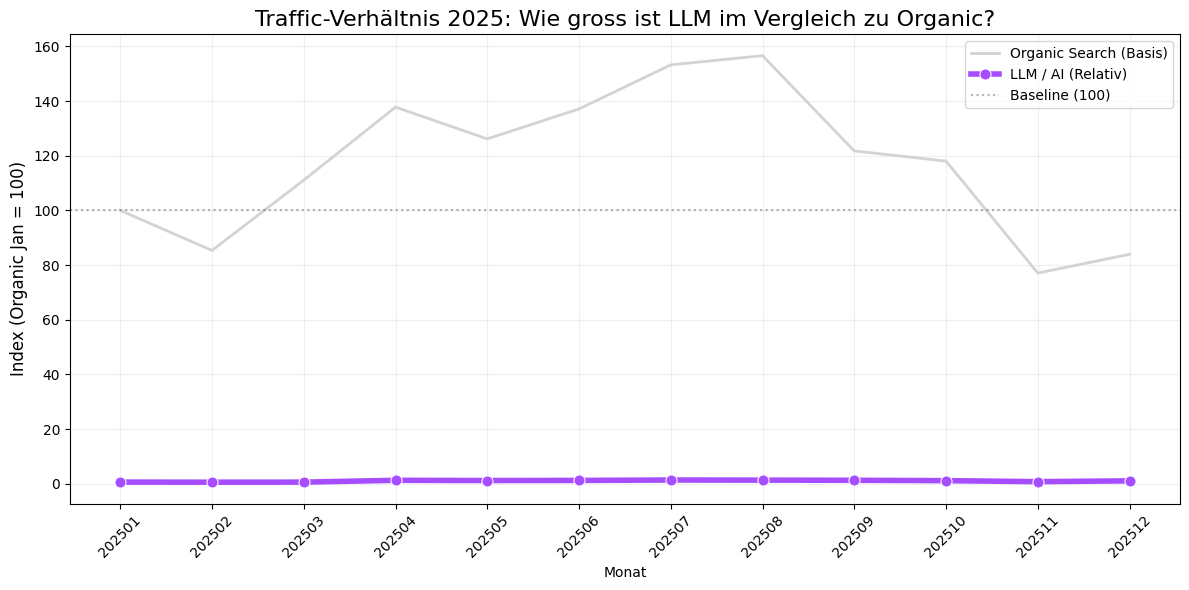

In [ ]:
# @title 📈 2025 Verhältnis-Analyse: Organic (Basis 100) vs. LLM
# ==============================================================================
# LOGIK-ÄNDERUNG:
# Index 100 = Organischer Traffic im Januar.
# Die LLM-Kurve zeigt das Volumen RELATIV zum organischen Startwert.
# (Beispiel: Index 1 bei LLM bedeutet, LLM hat 1% des organischen Volumens)
# ==============================================================================

import re
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from googleapiclient.discovery import build

# --- KONFIGURATION ---
START_DATE = "2025-01-01"
END_DATE   = "2025-12-31"

LLM_REGEX = r"^.*ai|.*\.openai.*|.*copilot.*|.*chatgpt.*|.*gemini.*|.*gpt.*|.*neeva.*|.*writesonic.*|.*nimble.*|.*outrider.*|.*perplexity.*|.*google.*bard.*|.*bard.*google.*|.*bard.*|.*edgeservices.*|.*astastic.*|.*copy\.ai.*|.*bnngpt.*|.*gemini.*google.*$"

def get_creds_smart():
    if 'creds' in globals() and globals()['creds'] and globals()['creds'].valid:
        return globals()['creds']
    try:
        return authenticate_analytics()
    except NameError:
        print("⚠️ Bitte Block 1 (Auth) zuerst ausführen.")
        return None

def classify_traffic_source(source, medium):
    s = str(source).lower()
    m = str(medium).lower()
    if re.match(LLM_REGEX, s): return "LLM / AI"
    if 'organic' in m: return "Organic Search"
    return "Other"

def run_relation_analysis_2025():
    creds = get_creds_smart()
    if not creds: return

    print(f"\n🚀 Berechne Verhältnis Organic vs. LLM (Basis: Organic Jan = 100)...")

    # Services & Properties
    try:
        admin_service = build('analyticsadmin', 'v1beta', credentials=creds)
        data_service = build('analyticsdata', 'v1beta', credentials=creds)
        acc_summary = admin_service.accountSummaries().list().execute()
        all_props = [p['property'].split('/')[1] for acc in acc_summary.get('accountSummaries', []) for p in acc.get('propertySummaries', [])]
        print(f"👉 Analysiere {len(all_props)} Properties...")
    except Exception as e:
        print(f"❌ Fehler: {e}")
        return

    # Datenabruf
    daily_aggs = []
    for p_id in tqdm(all_props, desc="Lade Daten"):
        try:
            req = {
                "dateRanges": [{"startDate": START_DATE, "endDate": END_DATE}],
                "dimensions": [{"name": "yearMonth"}, {"name": "sessionSource"}, {"name": "sessionMedium"}],
                "metrics": [{"name": "sessions"}]
            }
            res = data_service.properties().runReport(property=f"properties/{p_id}", body=req).execute()
            if 'rows' not in res: continue

            rows = []
            for r in res['rows']:
                rows.append({
                    'Month': r['dimensionValues'][0]['value'],
                    'Source': r['dimensionValues'][1]['value'],
                    'Medium': r['dimensionValues'][2]['value'],
                    'Sessions': int(r['metricValues'][0]['value'])
                })
            df = pd.DataFrame(rows)
            df['Channel'] = df.apply(lambda x: classify_traffic_source(x['Source'], x['Medium']), axis=1)
            daily_aggs.append(df.groupby(['Month', 'Channel'])['Sessions'].sum().reset_index())
            time.sleep(0.05)
        except: continue

    if not daily_aggs:
        print("❌ Keine Daten.")
        return

    # Aggregation
    full_df = pd.concat(daily_aggs)
    total_trend = full_df.groupby(['Month', 'Channel'])['Sessions'].sum().reset_index()
    relevant = total_trend[total_trend['Channel'].isin(['Organic Search', 'LLM / AI'])].copy()
    pivot = relevant.pivot(index='Month', columns='Channel', values='Sessions').fillna(0)

    # --- NEUE INDEX LOGIK ---
    pivot_idx = pd.DataFrame(index=pivot.index)

    try:
        # 1. Wir holen uns den absoluten Wert von Organic im Januar (oder ersten Monat)
        # Das ist unser universeller Teiler für ALLES.
        base_volume = pivot['Organic Search'].iloc[0]

        if base_volume == 0:
            print("❌ Fehler: Organischer Traffic im Startmonat ist 0. Kann keine Basis bilden.")
            return

        print(f"\nℹ️ BASIS-WERT (Index 100): {base_volume:,.0f} Organische Sessions im Startmonat.")

        # 2. Organic Index berechnen (Startet bei 100)
        pivot_idx['Organic Search'] = (pivot['Organic Search'] / base_volume) * 100

        # 3. LLM Index berechnen (Startet bei X, relativ zu Organic)
        # Wenn LLM 1% von Organic hat, steht hier 1.
        pivot_idx['LLM / AI'] = (pivot['LLM / AI'] / base_volume) * 100

    except Exception as e:
        print(f"❌ Fehler bei Berechnung: {e}")
        return

    print("\n" + "="*60)
    print("📈 INDEX-TABELLE (Organic Jan = 100)")
    print("="*60)
    print("Interpretation: Ein LLM-Wert von '2.5' bedeutet, dass LLM-Traffic")
    print("2.5% des Volumens vom organischen Traffic im Januar entspricht.")
    print("-" * 60)
    print(pivot_idx.round(2).to_markdown())

    # --- PLOTTING ---
    plt.figure(figsize=(12, 6))

    # Organic Plot
    sns.lineplot(data=pivot_idx, x=pivot_idx.index, y='Organic Search',
                 color='lightgray', linewidth=2, label='Organic Search (Basis)')

    # LLM Plot
    sns.lineplot(data=pivot_idx, x=pivot_idx.index, y='LLM / AI',
                 color='#a64eff', linewidth=4, marker='o', markersize=8, label='LLM / AI (Relativ)')

    # Beschriftung
    plt.axhline(100, color='black', linestyle=':', alpha=0.3, label='Baseline (100)')
    plt.title('Traffic-Verhältnis 2025: Wie gross ist LLM im Vergleich zu Organic?', fontsize=16)
    plt.ylabel('Index (Organic Jan = 100)', fontsize=12)
    plt.xlabel('Monat')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_relation_analysis_2025()

# LLM Solo-Analyse 2025 (Index 100 = Start)


🚀 Starte isolierte LLM-Analyse 2025...
👉 Scanne 15 Properties nach AI-Traffic...


Suche AI Traffic: 100%|██████████| 15/15 [00:08<00:00,  1.76it/s]



🤖 LLM WACHSTUM 2025 (Basis: 202501 = 100)
|   Month |   Sessions |   LLM Index |
|--------:|-----------:|------------:|
|  202501 |        224 |       100   |
|  202502 |        213 |        95.1 |
|  202503 |        220 |        98.2 |
|  202504 |        474 |       211.6 |
|  202505 |        441 |       196.9 |
|  202506 |        457 |       204   |
|  202507 |        513 |       229   |
|  202508 |        498 |       222.3 |
|  202509 |        476 |       212.5 |
|  202510 |        425 |       189.7 |
|  202511 |        288 |       128.6 |
|  202512 |        396 |       176.8 |


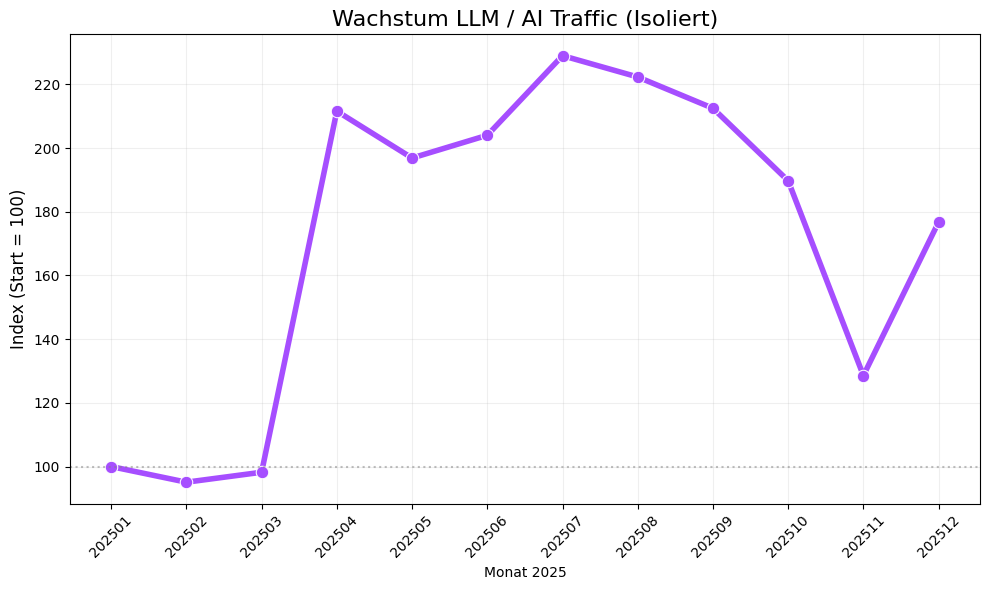

In [ ]:
# @title 🤖 LLM Solo-Analyse 2025 (Index 100 = Start)
# ==============================================================================
# Zeigt NUR die Entwicklung des LLM/AI Traffics.
# Der erste Monat (Januar) wird auf 100 gesetzt.
# Farbe: #a64eff
# ==============================================================================

import re
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from googleapiclient.discovery import build

# --- KONFIGURATION ---
START_DATE = "2025-01-01"
END_DATE   = "2025-12-31"

# Dein spezifischer Regex
LLM_REGEX = r"^.*ai|.*\.openai.*|.*copilot.*|.*chatgpt.*|.*gemini.*|.*gpt.*|.*neeva.*|.*writesonic.*|.*nimble.*|.*outrider.*|.*perplexity.*|.*google.*bard.*|.*bard.*google.*|.*bard.*|.*edgeservices.*|.*astastic.*|.*copy\.ai.*|.*bnngpt.*|.*gemini.*google.*$"

def get_creds_smart():
    if 'creds' in globals() and globals()['creds'] and globals()['creds'].valid:
        return globals()['creds']
    try:
        return authenticate_analytics()
    except NameError:
        print("⚠️ Bitte Block 1 (Auth) zuerst ausführen.")
        return None

def is_llm_traffic(source):
    """Prüft nur auf den LLM Regex."""
    return bool(re.match(LLM_REGEX, str(source).lower()))

def run_llm_solo_analysis():
    creds = get_creds_smart()
    if not creds: return

    print(f"\n🚀 Starte isolierte LLM-Analyse 2025...")

    # Setup
    try:
        admin_service = build('analyticsadmin', 'v1beta', credentials=creds)
        data_service = build('analyticsdata', 'v1beta', credentials=creds)

        # Properties laden
        acc_summary = admin_service.accountSummaries().list().execute()
        all_props = []
        for acc in acc_summary.get('accountSummaries', []):
            for p in acc.get('propertySummaries', []):
                all_props.append(p['property'].split('/')[1])

        print(f"👉 Scanne {len(all_props)} Properties nach AI-Traffic...")

    except Exception as e:
        print(f"❌ Fehler: {e}")
        return

    # Datenabruf
    monthly_llm_sessions = []

    for p_id in tqdm(all_props, desc="Suche AI Traffic"):
        try:
            req = {
                "dateRanges": [{"startDate": START_DATE, "endDate": END_DATE}],
                "dimensions": [{"name": "yearMonth"}, {"name": "sessionSource"}], # Medium brauchen wir hier nicht zwingend
                "metrics": [{"name": "sessions"}]
            }
            res = data_service.properties().runReport(property=f"properties/{p_id}", body=req).execute()

            if 'rows' not in res: continue

            for row in res['rows']:
                source = row['dimensionValues'][1]['value']

                # Filter greift direkt hier
                if is_llm_traffic(source):
                    month = row['dimensionValues'][0]['value']
                    sessions = int(row['metricValues'][0]['value'])

                    monthly_llm_sessions.append({'Month': month, 'Sessions': sessions})

        except:
            continue

    if not monthly_llm_sessions:
        print("❌ Keinen einzigen Session mit passendem LLM-Source gefunden.")
        return

    # --- AGGREGATION ---
    df = pd.DataFrame(monthly_llm_sessions)

    # Summe aller LLM Sessions pro Monat über alle Properties
    trend = df.groupby('Month')['Sessions'].sum().reset_index().sort_values('Month')

    # --- INDEX BERECHNUNG ---
    # Basis: Erster Monat = 100
    try:
        base_val = trend.iloc[0]['Sessions']
        start_month = trend.iloc[0]['Month']

        if base_val == 0:
            # Suche ersten Monat > 0
            first_valid = trend[trend['Sessions'] > 0].iloc[0]
            base_val = first_valid['Sessions']
            start_month = first_valid['Month']
            print(f"ℹ️ Startmonat hatte 0 Traffic. Basis verschoben auf: {start_month}")

        trend['LLM Index'] = (trend['Sessions'] / base_val) * 100

        print("\n" + "="*60)
        print(f"🤖 LLM WACHSTUM 2025 (Basis: {start_month} = 100)")
        print("="*60)
        print(trend[['Month', 'Sessions', 'LLM Index']].round(1).to_markdown(index=False))

        # --- PLOT ---
        plt.figure(figsize=(10, 6))

        sns.lineplot(data=trend, x='Month', y='LLM Index',
                     color='#a64eff', linewidth=4, marker='o', markersize=9)

        plt.axhline(100, color='gray', linestyle=':', alpha=0.5)
        plt.title('Wachstum LLM / AI Traffic (Isoliert)', fontsize=16)
        plt.ylabel('Index (Start = 100)', fontsize=12)
        plt.xlabel('Monat 2025')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Fehler bei der Berechnung: {e}")

if __name__ == "__main__":
    run_llm_solo_analysis()

# Conversion Rate Analyse 2025: Organic vs. LLM


🚀 Berechne Conversion Rate Vergleich (2025)...
👉 Analysiere Qualität von 15 Properties...


Lade Daten: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]



💰 CONVERSION RATE (%) IM VERGLEICH
|   Month |   LLM / AI |   Organic Search |
|--------:|-----------:|-----------------:|
|  202501 |     184.82 |           175.29 |
|  202502 |     164.79 |           177.56 |
|  202503 |     160    |           172.93 |
|  202504 |     174.11 |           164.85 |
|  202505 |     151.47 |           168.29 |
|  202506 |     141.7  |           164.53 |
|  202507 |     148.34 |           167.49 |
|  202508 |     110.84 |           162.9  |
|  202509 |     132.14 |           166.58 |
|  202510 |     121.65 |           170.36 |
|  202511 |     136.81 |           159.98 |
|  202512 |     174.81 |           159.39 |


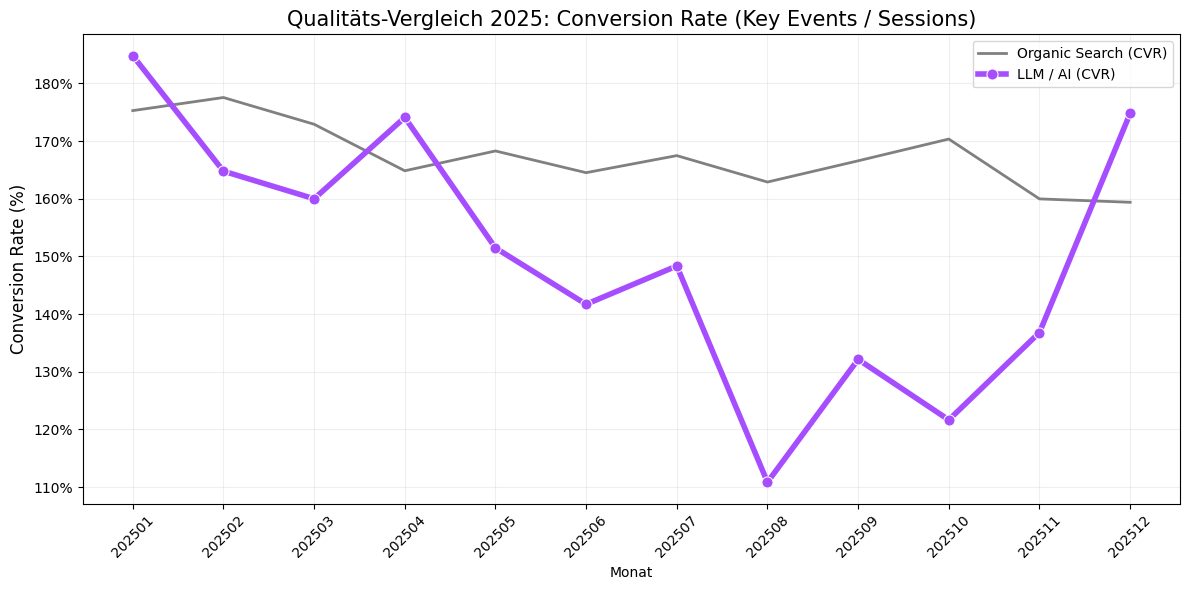

In [ ]:
# @title 💰 Conversion Rate Analyse 2025: Organic vs. LLM
# ==============================================================================
# Vergleicht die Qualität des Traffics (KeyEvents / Sessions * 100)
# Farbe LLM: #a64eff
# Zeitraum: Jan - Dez 2025
# ==============================================================================

import re
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm
from googleapiclient.discovery import build

# --- KONFIGURATION ---
START_DATE = "2025-01-01"
END_DATE   = "2025-12-31"

# Dein spezifischer Regex
LLM_REGEX = r"^.*ai|.*\.openai.*|.*copilot.*|.*chatgpt.*|.*gemini.*|.*gpt.*|.*neeva.*|.*writesonic.*|.*nimble.*|.*outrider.*|.*perplexity.*|.*google.*bard.*|.*bard.*google.*|.*bard.*|.*edgeservices.*|.*astastic.*|.*copy\.ai.*|.*bnngpt.*|.*gemini.*google.*$"

def get_creds_smart():
    if 'creds' in globals() and globals()['creds'] and globals()['creds'].valid:
        return globals()['creds']
    try:
        return authenticate_analytics()
    except NameError:
        print("⚠️ Bitte Block 1 (Auth) zuerst ausführen.")
        return None

def classify_traffic_source(source, medium):
    s = str(source).lower()
    m = str(medium).lower()

    # 1. Regex Check (Priorität)
    if re.match(LLM_REGEX, s):
        return "LLM / AI"

    # 2. Organic Search
    if 'organic' in m:
        return "Organic Search"

    return "Other"

def get_conversion_data(service, property_id):
    """Holt Sessions UND KeyEvents (mit Fallback auf Conversions)."""
    # Wir brauchen beides: Sessions (Nenner) und KeyEvents (Zähler)
    metrics_try = [{"name": "sessions"}, {"name": "keyEvents"}]

    req = {
        "dateRanges": [{"startDate": START_DATE, "endDate": END_DATE}],
        "dimensions": [{"name": "yearMonth"}, {"name": "sessionSource"}, {"name": "sessionMedium"}],
        "metrics": metrics_try
    }

    try:
        return service.properties().runReport(property=f"properties/{property_id}", body=req).execute()
    except Exception as e:
        # Fallback für alte Properties (legacy 'conversions')
        if "keyEvents" in str(e) or "400" in str(e):
            req['metrics'] = [{"name": "sessions"}, {"name": "conversions"}]
            try:
                return service.properties().runReport(property=f"properties/{property_id}", body=req).execute()
            except:
                return None
        return None

def run_cvr_analysis_2025():
    creds = get_creds_smart()
    if not creds: return

    print(f"\n🚀 Berechne Conversion Rate Vergleich (2025)...")

    # Services
    try:
        admin_service = build('analyticsadmin', 'v1beta', credentials=creds)
        data_service = build('analyticsdata', 'v1beta', credentials=creds)

        acc_summary = admin_service.accountSummaries().list().execute()
        all_props = []
        for acc in acc_summary.get('accountSummaries', []):
            for p in acc.get('propertySummaries', []):
                all_props.append(p['property'].split('/')[1])

        print(f"👉 Analysiere Qualität von {len(all_props)} Properties...")

    except Exception as e:
        print(f"❌ Fehler: {e}")
        return

    # Daten sammeln
    raw_data = []

    for p_id in tqdm(all_props, desc="Lade Daten"):
        res = get_conversion_data(data_service, p_id)

        if not res or 'rows' not in res: continue

        for r in res['rows']:
            sessions = int(r['metricValues'][0]['value'])
            conversions = float(r['metricValues'][1]['value'])

            # Nur Daten speichern, wenn Traffic da ist
            if sessions > 0:
                raw_data.append({
                    'Month': r['dimensionValues'][0]['value'],
                    'Source': r['dimensionValues'][1]['value'],
                    'Medium': r['dimensionValues'][2]['value'],
                    'Sessions': sessions,
                    'Conversions': conversions
                })

        time.sleep(0.05)

    if not raw_data:
        print("❌ Keine Daten verfügbar.")
        return

    # --- AGGREGATION ---
    df = pd.DataFrame(raw_data)

    # Klassifizieren
    df['Channel'] = df.apply(lambda x: classify_traffic_source(x['Source'], x['Medium']), axis=1)

    # Wir filtern nur Organic und LLM
    df = df[df['Channel'].isin(['Organic Search', 'LLM / AI'])]

    # Gruppieren über ALLE Properties (Portfolio View)
    # Summe Conversions / Summe Sessions = Wahre Portfolio CVR
    grouped = df.groupby(['Month', 'Channel']).agg({
        'Sessions': 'sum',
        'Conversions': 'sum'
    }).reset_index()

    # CVR Berechnen
    grouped['CVR %'] = (grouped['Conversions'] / grouped['Sessions']) * 100

    # Pivot für Tabelle
    pivot = grouped.pivot(index='Month', columns='Channel', values='CVR %').fillna(0)

    print("\n" + "="*60)
    print("💰 CONVERSION RATE (%) IM VERGLEICH")
    print("="*60)
    print(pivot.round(2).to_markdown())

    # --- PLOTTING ---
    plt.figure(figsize=(12, 6))

    # Organic Linie
    sns.lineplot(data=grouped[grouped['Channel']=='Organic Search'], x='Month', y='CVR %',
                 color='gray', linewidth=2, label='Organic Search (CVR)')

    # LLM Linie
    sns.lineplot(data=grouped[grouped['Channel']=='LLM / AI'], x='Month', y='CVR %',
                 color='#a64eff', linewidth=4, marker='o', markersize=8, label='LLM / AI (CVR)')

    plt.title('Qualitäts-Vergleich 2025: Conversion Rate (Key Events / Sessions)', fontsize=15)
    plt.ylabel('Conversion Rate (%)', fontsize=12)
    plt.xlabel('Monat')

    # Y-Achse als Prozent formatieren
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_cvr_analysis_2025()